<a href="https://colab.research.google.com/github/javmencia/RelativeBelief/blob/main/BiasCalculations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

from scipy import stats


In [3]:
def normal_logp(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - pm.math.log(sigma) - 0.5*pm.math.log(2*np.pi)
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5*np.log(2*np.pi)

# Hypothesis

## Bias against

Model

In [62]:

mu_prior_mean = 0
mu_prior_sigma = 1
n=50
mu_0 = 0
with pm.Model() as m:

    # traditional analysis
    # mu = pm.Normal('mu', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=1)
    # y = pm.Normal('y', mu=mu, sigma=1, observed=x)

    # "empty model" MCMC sample over prior and prior predictive data
    mu_ = pm.Normal('mu_', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=1)
    x_ = pm.Normal('x_', mu=mu_0, sigma=1, shape=n)

    # prior predictive data density evaluations
    prior_prior_pd = pm.Deterministic("prior_prior_pd", normal_logp(mu_0,0,1))

    posterior_var = 1/(1/mu_prior_sigma**2 + n/1)
    posterior_mean = (mu_prior_mean/mu_prior_sigma**2 + x_.sum()/1)*posterior_var
    posterior_prior_pd = pm.Deterministic("posterior_prior_pd",
                                          normal_logp(mu_0, posterior_mean, posterior_var**0.5))
    logBR_prior_pd = pm.Deterministic("logBR_prior_pd", posterior_prior_pd-prior_prior_pd) # pm.math.exp()

    likelihood_prior_pd = pm.Deterministic("likelihood_prior_pd", normal_logp(x_,mu_0,1).sum())

with m:
    idata = pm.sample(draws=1000)

### Analytic (using posterior density)

In [63]:
bias_against = idata.posterior['logBR_prior_pd'].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum()/np.arange(1,t+1)

### Simulation (estimating marginal likelihood)

In [64]:
use = 1000
marginal_likelihoods = np.zeros(list(idata.posterior['x_'].values.shape)+[use])
for i,m in enumerate(idata.posterior['mu_'].values.ravel()[:use]):
    marginal_likelihoods[:,:,:,i] = normal_logp_np(idata.posterior['x_'].values,m,1) # getting likelihoods for each x_ under each mu_

marginal_likelihoods_ = np.log(np.exp(marginal_likelihoods.sum(axis=2)).mean(axis=-1).ravel()) # summing the log likelihoods and then taking the average over the parameter samples
bias_against_ml = (idata.posterior['likelihood_prior_pd'].values.ravel()-marginal_likelihoods_) <= 0
bias_against_ml_mci = bias_against_ml.cumsum()/np.arange(1,t+1)


#### Plot

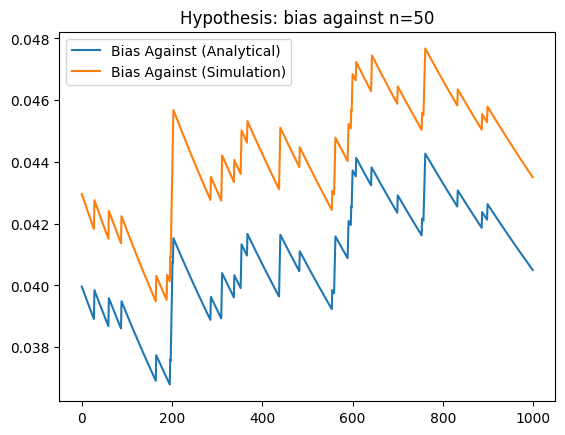

In [65]:
plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: bias against n=50")
plt.legend()

## Bias in favor in **1D**

In [4]:
mu_prior_mean = 0
mu_prior_sigma = 1
n=50
mu_0 = 0
delta = 0.05
mu_lower = mu_0 - delta
mu_upper = mu_0 + delta
with pm.Model() as m:

    # traditional analysis
    # mu = pm.Normal('mu', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=1)
    # y = pm.Normal('y', mu=mu, sigma=1, observed=x)

    # "empty model" MCMC sample over prior and prior predictive data
    mu_ = pm.Normal('mu_', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=1)
    xl_ = pm.Normal('xl_', mu=mu_lower, sigma=1, shape=n)
    xu_ = pm.Normal('xu_', mu=mu_upper, sigma=1, shape=n)

    # prior predictive data density evaluations
    prior_prior_pd = pm.Deterministic("prior_prior_pd", normal_logp(mu_0,0,1))

    posterior_var = 1/(1/mu_prior_sigma**2 + n/1)

    posterior_meanl = (mu_prior_mean/mu_prior_sigma**2 + xl_.sum()/1)*posterior_var
    posterior_meanu = (mu_prior_mean/mu_prior_sigma**2 + xu_.sum()/1)*posterior_var

    posterior_prior_pdl = pm.Deterministic("posterior_prior_pdl",
                                          normal_logp(mu_0, posterior_meanl, posterior_var**0.5))
    posterior_prior_pdu = pm.Deterministic("posterior_prior_pdu",
                                          normal_logp(mu_0, posterior_meanu, posterior_var**0.5))

    logBR_prior_pdl = pm.Deterministic("logBR_prior_pdl", posterior_prior_pdl-prior_prior_pd) # pm.math.exp()
    logBR_prior_pdu = pm.Deterministic("logBR_prior_pdu", posterior_prior_pdu-prior_prior_pd) # pm.math.exp()

    likelihood_prior_pdlower = pm.Deterministic("likelihood_prior_pdlower", normal_logp(xl_,mu_0,1).sum())
    likelihood_prior_pdupper = pm.Deterministic("likelihood_prior_pdupper", normal_logp(xu_,mu_0,1).sum())

with m:
    idata = pm.sample(draws=1000)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() > 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() > 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)

use = 1000
marginal_likelihoodslower = np.zeros(list(idata.posterior['xl_'].values.shape)+[use])
for i,m in enumerate(idata.posterior['mu_'].values.ravel()[:use]):
    marginal_likelihoodslower[:,:,:,i] = normal_logp_np(idata.posterior['xl_'].values,m,1) # getting likelihoods for each x_ under each mu_

marginal_likelihoodsupper = np.zeros(list(idata.posterior['xu_'].values.shape)+[use])
for i,m in enumerate(idata.posterior['mu_'].values.ravel()[:use]):
    marginal_likelihoodsupper[:,:,:,i] = normal_logp_np(idata.posterior['xu_'].values,m,1)



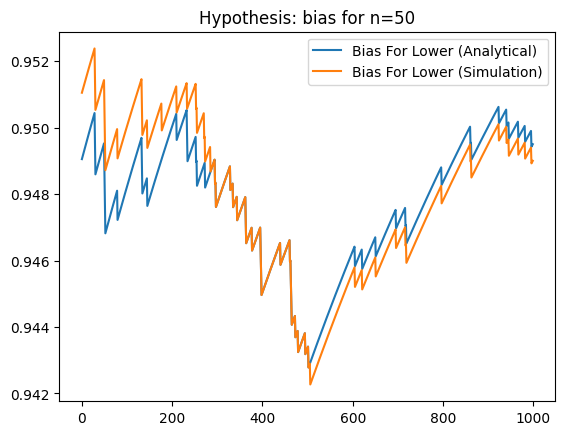

In [5]:
marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoodslower.sum(axis=2)).mean(axis=-1).ravel()) # summing the log likelihoods and then taking the average over the parameter samples
bias_for_mllower = (idata.posterior['likelihood_prior_pdlower'].values.ravel()-marginal_likelihoods_lower) > 0
bias_for_ml_mcilower = bias_for_mllower.cumsum()/np.arange(1,tl+1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mcilower[burn:], label='Bias For Lower (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()

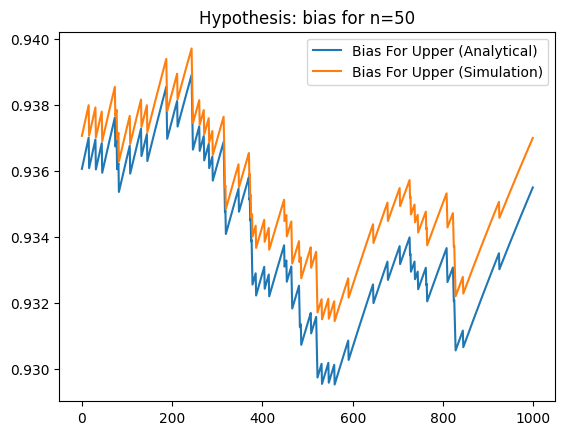

In [6]:
marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoodsupper.sum(axis=2)).mean(axis=-1).ravel()) # summing the log likelihoods and then taking the average over the parameter samples
bias_for_mlupper = (idata.posterior['likelihood_prior_pdupper'].values.ravel()-marginal_likelihoods_upper) > 0
bias_for_ml_mciupper = bias_for_mlupper.cumsum()/np.arange(1,tl+1)

plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mciupper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()

#### Another example for bias in favor

Using specification from Example 2 in this paper, where true value of bias in favor is 0.692:

Michael Evans (2016),Measuring statistical evidence using relative belief,
Computational and Structural Biotechnology Journal,
Volume 14, Pages 91-96, ISSN 2001-0370,
https://doi.org/10.1016/j.csbj.2015.12.001.

Analytically (Using posterior density)

[0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1
 1 1 0 0 0 0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 0 0 1 1 1 0 0 0 0 1 1 1 0 1 1 1 1
 1 0 1 1 1 1 0 1 0 0 0 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0]
[1 0 1 0 0 0 0 0 1 1 1 0 1 0 0 1 1 0 1 0 1 1 0 0 0 1 1 1 1 1 0 0 1 1 0 1 0
 1 0 1 0 1 0 1 0 1 1 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 1 1 1 0 0 1 0 0 1 1 0 0
 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 0 0 0]


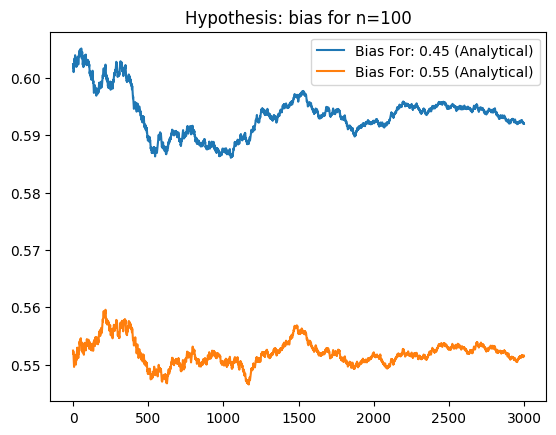

In [98]:
delta = 0.05
n = 100
theta0 = 0.5
data1 = np.random.binomial(1, theta0+delta, n)
data2 = np.random.binomial(1,theta0-delta, n)

alpha0 = 4
beta0 = 4

print(data1)
print(data2)

with pm.Model() as modBias:
    theta = pm.Beta('theta', alpha = alpha0, beta = beta0)

    posterior_pd1 = pm.Beta('posterior_pd1', alpha = np.sum(data1)+alpha0, beta = n-np.sum(data1)+beta0)
    posterior_pd2 = pm.Beta('posterior_pd2', alpha = np.sum(data2)+alpha0, beta = n-np.sum(data2)+beta0)

    BR_prior_pd1 = pm.Deterministic("BR_prior_pd1", posterior_pd1/theta)
    BR_prior_pd2 = pm.Deterministic("BR_prior_pd2", posterior_pd2/theta)

    # Sample from posterior
    trace = pm.sample(2000, tune=1000)

bias_forlower = trace.posterior['BR_prior_pd1'].values.ravel() > 1
bias_forupper = trace.posterior['BR_prior_pd2'].values.ravel() > 1
tlower = bias_forlower.shape[0]
tupper = bias_forupper.shape[0]
burn = 1000
bias_forlower_mci = bias_forlower.cumsum()/np.arange(1,tlower+1)
bias_forupper_mci = bias_forupper.cumsum()/np.arange(1,tupper+1)
plt.plot(bias_forlower_mci[burn:], label='Bias For: 0.45 (Analytical)')
plt.plot(bias_forupper_mci[burn:], label='Bias For: 0.55 (Analytical)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()

Simulation (estimating marginal likelihood)

In [127]:
delta = 0.05
n = 100
theta0 = 0.5
data1 = np.random.binomial(1, theta0+delta, n)
data2 = np.random.binomial(1,theta0-delta, n)

alpha0 = 4
beta0 = 4

print(data1)
print(data2)

with pm.Model() as modBias:
    theta = pm.Beta('theta', alpha = alpha0, beta = beta0)

    posterior_pd1 = pm.Beta('posterior_pd1', alpha = np.sum(data1)+alpha0, beta = n-np.sum(data1)+beta0)
    posterior_pd2 = pm.Beta('posterior_pd2', alpha = np.sum(data2)+alpha0, beta = n-np.sum(data2)+beta0)

    BR_prior_pd1 = pm.Deterministic("BR_prior_pd1", posterior_pd1/theta)
    BR_prior_pd2 = pm.Deterministic("BR_prior_pd2", posterior_pd2/theta)


    likelihood1 = pm.Binomial('likelihood1', n=n, p=theta, observed=data1)
    lik1 = pm.Deterministic('lik1', likelihood1)
    likelihood2 = pm.Binomial('likelihood2', n=n, p=theta, observed=data2)
    lik2 = pm.Deterministic('lik2', likelihood2)


with modBias:
    # Sample from posterior
    trace = pm.sample(2000, tune=1000)

use = 1000  # Number of samples to use

marginal_likelihoods1 = np.zeros((list(trace.posterior['posterior_pd1'].values.shape)+[use]))
marginal_likelihoods2 = np.zeros((list(trace.posterior['posterior_pd2'].values.shape)+[use]))


for i, m in enumerate(trace.posterior['theta'].values.ravel()[:use]):
    alpha1 = np.sum(data1) + alpha0
    beta1 = n - np.sum(data1) + beta0
    marginal_likelihoods1[:, :, i] = stats.beta.pdf(m, alpha1, beta1)

    alpha2 = np.sum(data2) + alpha0
    beta2 = n - np.sum(data2) + beta0
    marginal_likelihoods2[:, :, i] =stats.beta.pdf(m, alpha2, beta2)

bias_against_ml1 = (trace.posterior['lik1'].values.ravel()/marginal_likelihoods1) > 1
bias_against_ml1_mci = bias_against_ml1.cumsum()/np.arange(1,t+1)
plt.plot(bias_against_ml1_mci[use:]);

bias_against_ml2 = (trace.posterior['lik2'].values.ravel()/marginal_likelihoods2) > 1
bias_against_ml2_mci = bias_against_ml2.cumsum()/np.arange(1,t+1)
plt.plot(bias_against_ml2_mci[use:]);


[0 0 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 1 1 0 0 1 1 1 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 0 1 0 1 1 1 0 1
 1 1 0 0 0 1 1 0 0 1 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0]
[0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0
 1 1 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 0 1 1 0 0 0 1 1 0 1 0 1 1 1 0 0 1 0 1 0
 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 1 1]


[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
[[[5.07833924e-88 2.60434520e-88 5.41676827e-86 ... 3.93963859e-87
   6.84695830e-90 4.84662265e-88]
  [5.07833924e-88 2.60434520e-88 5.41676827e-86 ... 3.93963859e-87
   6.84695830e-90 4.84662265e-88]
  [5.07833924e-88 2.60434520e-88 5.41676827e-86 ... 3.93963859e-87
   6.84695830e-90 4.84662265e-88]
  ...
  [5.07833924e-88 2.60434520e-88 5.41676827e-86 ... 3.93963859e-87
   6.84695830e-90 4.84662265e-88]
  [5.07833924e-88 2.60434520e-88 5.41676827e-86 ... 3.93963859e-87
   6.84695830e-90 4.84662265e-88]
  [5.07833924e-88 2.60434520e-88 5.41676827e-86 ... 3.93963859e-87
   6.84695830e-90 4.84662265e-88]]

 [[5.07833924e-88 2.60434520e-88 5.41676827e-86 ... 3.9396

ValueError: operands could not be broadcast together with shapes (400000,) (2,2000,1000) 

# Estimation

Model

In [57]:
n = 50
x = stats.norm.rvs(size=n)
mu_prior_mean = 0
mu_prior_sigma = 1
with pm.Model() as m:

    # traditional analysis
    mu = pm.Normal('mu', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=1)
    y = pm.Normal('y', mu=mu, sigma=1, observed=x)

    # "empty model" MCMC sample over prior and prior predictive data
    mu_ = pm.Normal('mu_', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=1)
    x_ = pm.Normal('x_', mu=mu_, sigma=1, shape=n)

    # prior predictive data density evaluations
    prior_prior_pd = pm.Deterministic("prior_prior_pd", normal_logp(mu_,0,1))

    posterior_var = 1/(1/mu_prior_sigma**2 + n/1)
    posterior_mean = (mu_prior_mean/mu_prior_sigma**2 + x_.sum()/1)*posterior_var
    posterior_prior_pd = pm.Deterministic("posterior_prior_pd",
                                          normal_logp(mu_, posterior_mean, posterior_var**0.5))
    logRB_prior_pd = pm.Deterministic("logRB_prior_pd", posterior_prior_pd-prior_prior_pd) # pm.math.exp()

    likelihood_prior_pd = pm.Deterministic("likelihood_prior_pd", normal_logp(x_,mu_,1).sum())

with m:
    idata = pm.sample(draws=1000) #Makes meginal likelihood estimation more accurate)

## Bias against

### Analytic (using posterior density)

In [58]:
bias_against = idata.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against.shape[0]
bias_against_mci = bias_against.cumsum()/np.arange(1,t+1)
burn = 1000


### Simulation (Estimating marginal likelihood)

In [59]:
use = 1000
marginal_likelihoods = np.zeros(list(idata.posterior['x_'].values.shape)+[use])
for i,m in enumerate(idata.posterior['mu_'].values.ravel()[:use]):
    marginal_likelihoods[:,:,:,i] = normal_logp_np(idata.posterior['x_'].values,m,1)
marginal_likelihoods = np.log(np.exp(marginal_likelihoods.sum(axis=2)).mean(axis=-1).ravel())

bias_against = idata.posterior['logRB_prior_pd'].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum()/np.arange(1,t+1)


bias_against_ml = (idata.posterior['likelihood_prior_pd'].values.ravel()-marginal_likelihoods) <= 0
bias_against_ml_mci = bias_against_ml.cumsum()/np.arange(1,t+1)


#### Plot

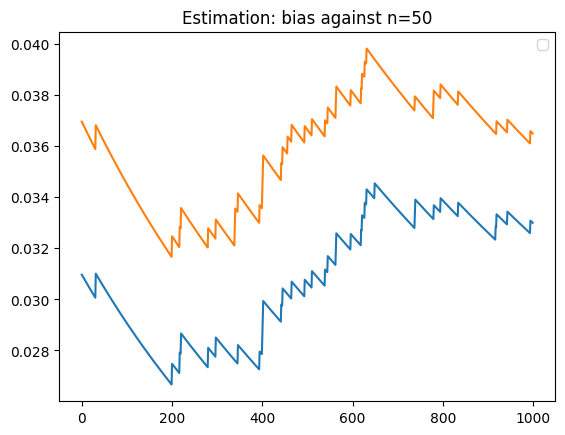

In [61]:
plt.plot(bias_against_mci[burn:])
plt.plot(bias_against_ml_mci[burn:]);
plt.title("Estimation: bias against n={}".format(n))
plt.legend()

## Bias in favor in 1D

### Analytic (Using posterior density)

In [ ]:
#Not done yet

### Simulation (Estimating marginal likelihood)

In [ ]:
#Not done yet

# Relative Belief ratios

In [81]:
np.random.seed(1234)
data = np.random.uniform(0, 10, size=100)
with pm.Model() as model:
    # Prior
    mu = pm.Normal('mu', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=10)

    # Likelihood
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=data)

    # Sample posterior
    trace = pm.sample(2000, tune=1000)

# Extract posterior samples
posterior_samples = trace.posterior['mu'].values.flatten()




<ipython-input-84-ec3d2a285357>:40: RuntimeWarning: invalid value encountered in divide
  rbr = smoothed_posterior_hist / smoothed_prior_hist


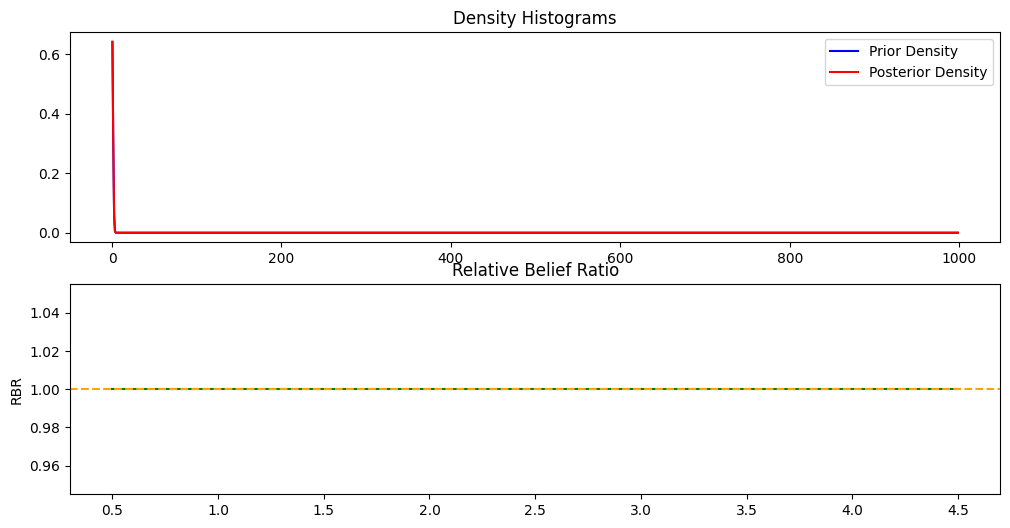

In [84]:
n = 100
theta0 = 0.5
data = np.random.binomial(1, theta0, n)

alpha0 = 4
beta0 = 4

# Create the PyMC3 model
with pm.Model() as modBias:
    # Prior distribution
    theta_prior = pm.Beta('theta', alpha=alpha0, beta=beta0)

    # Likelihood
    likelihood = pm.Binomial('likelihood', n=n, p=theta0, observed=data)

    # Posterior distribution
    posterior = pm.Beta('posterior', alpha=np.sum(data) + alpha0, beta=n - np.sum(data) + beta0)

    # Calculate the ratio of posterior to prior
    #BR_prior_pd1 = pm.Deterministic("BR_prior_pd1", posterior / theta_prior)

    # Sample the model
    trace = pm.sample(2000, tune=1000)

delta = 1
bins = np.arange(0, 1000, delta)

# Prior histogram
prior_samples = np.random.beta(alpha0, beta0, size=10000)
prior_hist, _ = np.histogram(prior_samples, bins=bins, density=True)

# Posterior histogram
posterior_hist, _ = np.histogram(trace.posterior['posterior'], bins=bins, density=True)

# Smoothing
smoothed_prior_hist = gaussian_filter1d(prior_hist, sigma=1)
smoothed_posterior_hist = gaussian_filter1d(posterior_hist, sigma=1)

# Compute RBR by taking ratio
rbr = smoothed_posterior_hist / smoothed_prior_hist

# Plotting
bin_centers = 0.5 * (bins[1:] + bins[:-1])

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(bin_centers, smoothed_prior_hist, label='Prior Density', color='blue')
plt.plot(bin_centers, smoothed_posterior_hist, label='Posterior Density', color='red')
plt.legend()
plt.title('Density Histograms')

plt.subplot(2, 1, 2)
plt.plot(bin_centers, rbr, color='green')
plt.title('Relative Belief Ratio')
plt.ylabel('RBR')
plt.axhline(y=1, color='orange', linestyle='--')
plt.show()

### Analytic (Using posterior and prior ratio)

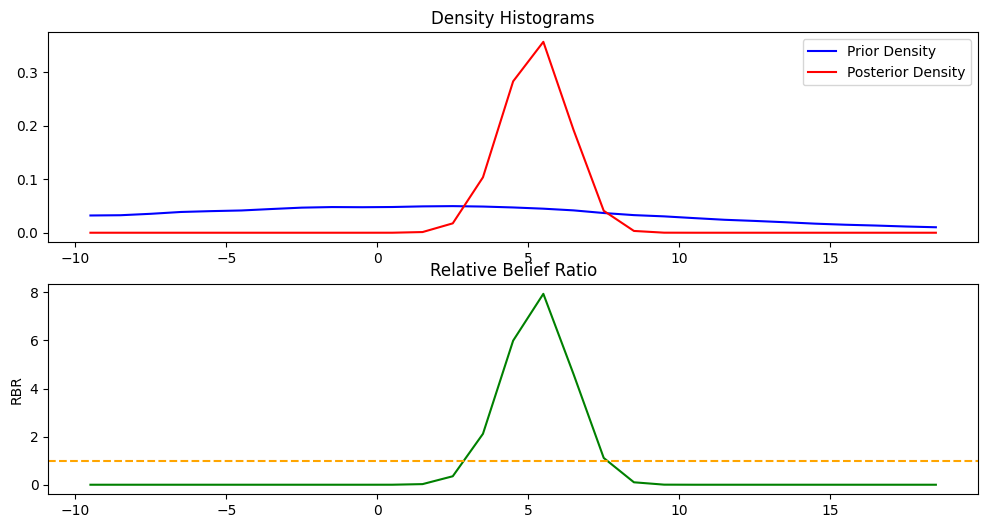

In [69]:
delta = 1 #Meaningful difference
bins = np.arange(-10, 20, delta)

# Prior histogram
prior_samples = np.random.normal(0, 10, size=10000)
prior_hist, _ = np.histogram(prior_samples, bins=bins, density=True)

# Posterior histogram
posterior_hist, _ = np.histogram(posterior_samples, bins=bins, density=True)

# Smoothing
smoothed_prior_hist = gaussian_filter1d(prior_hist, sigma=1)
smoothed_posterior_hist = gaussian_filter1d(posterior_hist, sigma=1)

# Compute RBR by taking ratio
rbr = smoothed_posterior_hist / smoothed_prior_hist

# Plotting
bin_centers = 0.5 * (bins[1:] + bins[:-1])

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(bin_centers, smoothed_prior_hist, label='Prior Density', color='blue')
plt.plot(bin_centers, smoothed_posterior_hist, label='Posterior Density', color='red')
plt.legend()
plt.title('Density Histograms')

plt.subplot(2, 1, 2)
plt.plot(bin_centers, rbr, color='green')
plt.title('Relative Belief Ratio')
plt.ylabel('RBR')
plt.axhline(y=1, color='orange', linestyle='--')
plt.show()


### Simulation

In [ ]:
#Not done yet